In [1]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from transformers import AdamW
import math
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [38]:
df = pd.read_csv("data.csv")
df

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
...,...,...
226829,Но не каждый хочет что то исправлять:( http://...,0
226830,скучаю так :-( только @taaannyaaa вправляет мо...,0
226831,"Вот и в школу, в говно это идти уже надо(",0
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0


In [45]:
texts = df["text"].tolist()
labels = df["label"].tolist()

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: nn.Module, num_classes: int):
      super().__init__()
      self.backbone = base_transformer_model
      self.linear = nn.Linear(self.backbone.config.hidden_size, num_classes)
      self.activation = nn.Tanh()

    def forward(self, x, attention_mask):
        features = self.backbone(x, attention_mask=attention_mask)
        out = features.last_hidden_state[:, 0, :]
        out = self.activation(out)
        out = self.linear(out)
        return out

In [48]:
def freeze_backbone_function(model):
    for param in model.parameters():
      param.requires_grad = False
    return model

In [49]:
sigmoid = nn.Sigmoid()
def train_transformer(transformer_model, num_epochs, train_texts, train_labels, valid_texts, valid_labels, batch_size, freeze_backbone=True):
  if freeze_backbone:
      transformer_model = freeze_backbone_function(transformer_model)


  model = TransformerClassificationModel(transformer_model, 1)
  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=1e-4)
  model.to(device)

  for epoch in range(1, num_epochs + 1):
    epoch_loss_train = 0
    model.train()
    with tqdm(total=math.ceil(train_texts['input_ids'].size(0) / batch_size), desc=f'Epoch {epoch}', unit='batch') as pbar:
      for i in range(0, train_texts['input_ids'].size(0), batch_size):
        texts_batch = train_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = train_texts["attention_mask"][i : i + batch_size].to(device)
        label_batch = train_labels[i : i + batch_size].float().to(device)

        optimizer.zero_grad()
        preds = model(texts_batch, masks_batch)
        loss = criterion(preds.squeeze(), label_batch)
        loss.backward()
        optimizer.step()

        epoch_loss_train += loss.item()
        pbar.update(1)

    model.eval()
    with torch.no_grad():
      epoch_loss_valid = 0
      accuracy = 0
      count = 0
      for i in range(0, valid_texts['input_ids'].size(0), batch_size):
        texts_batch = valid_texts["input_ids"][i : i + batch_size].to(device)
        masks_batch = valid_texts["attention_mask"][i : i + batch_size].to(device)
        label_batch = valid_labels[i : i + batch_size].float().to(device)
        preds = model(texts_batch, masks_batch)
        loss = criterion(preds.squeeze(), label_batch)
        epoch_loss_valid += loss.item()
        threshold = 0.5
        binary_preds = (sigmoid(preds.squeeze()) > threshold).int().detach().cpu().numpy()
        accuracy += accuracy_score(label_batch.detach().cpu().numpy(), binary_preds)
        count += 1

    print(f"Epoch №{epoch}; Train Loss: {epoch_loss_train / math.ceil(train_texts['input_ids'].size(0) / batch_size):.4f}; Eval Loss: {epoch_loss_valid / count:.4f}; Accuracy: {accuracy / count:.3f}")

  finetuned_model = model
  return finetuned_model

In [50]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels,
                                                                      test_size=0.15, random_state=42,
                                                                      shuffle=True)######

In [54]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
tokenized_train_texts = tokenizer(train_texts, return_tensors="pt", padding="max_length", max_length=20, truncation=True)
tokenized_test_texts = tokenizer(test_texts, return_tensors="pt", padding="max_length", max_length=20, truncation=True)

for key, values in tokenized_train_texts.items():
    values_type = type(values).__name__
    print(f"{key}: {values_type}, {values.shape}")
tokenized_train_texts["input_ids"]

input_ids: Tensor, torch.Size([192808, 20])
token_type_ids: Tensor, torch.Size([192808, 20])
attention_mask: Tensor, torch.Size([192808, 20])


tensor([[    2, 74905, 32203,  ...,     0,     0,     0],
        [    2,  4317,   321,  ...,     0,     0,     0],
        [    2,  6796,  8501,  ...,     0,     0,     0],
        ...,
        [    2,  6387,  1810,  ...,     0,     0,     0],
        [    2, 38118, 42274,  ...,     0,     0,     0],
        [    2,  4045, 24226,  ...,     0,     0,     0]])

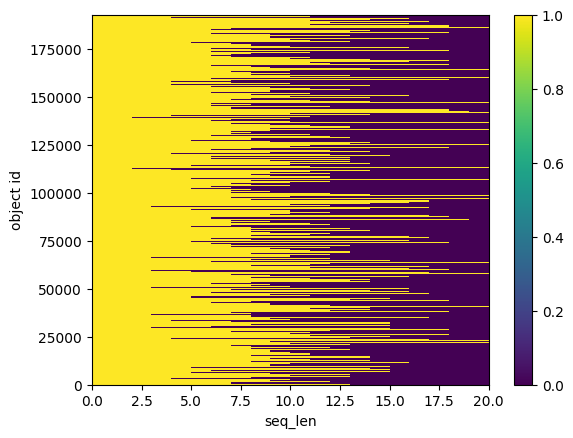

In [55]:
import matplotlib.pyplot as plt

plt.pcolormesh(tokenized_train_texts["attention_mask"])
plt.xlabel("seq_len")
plt.ylabel("object id")
plt.colorbar()
plt.show()

In [53]:
decoded_train_texts = [tokenizer.decode(tokenized_train_texts['input_ids'][2], skip_special_tokens=False)]


# Печать результатов
print("Токенизированный тренировочный текст:")
for text, tokenized_text in zip(train_texts, decoded_train_texts):
    print("Исходный текст:", text)
    print("Токенизированный текст:", tokenized_text)
    break

Токенизированный тренировочный текст:
Исходный текст: сумка завтра собирать какой завтра урок
Токенизированный текст: [CLS] бывать сдавать экзамен вторник четверг преподаватель умирать жаль очень офигенный мужик [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [56]:
rubert_tiny_transformer_model_freeze = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
rubert_tiny_finetuned = train_transformer(rubert_tiny_transformer_model_freeze, num_epochs=30,
                                                                train_texts=tokenized_train_texts, train_labels=torch.tensor(train_labels),
                                                                valid_texts=tokenized_test_texts, valid_labels=torch.tensor(test_labels),
                                                                batch_size=128, freeze_backbone=False)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 1507/1507 [00:41<00:00, 36.39batch/s]


Epoch №1; Train Loss: 306.6445; Eval Loss: 302.8357; Accuracy: 0.708


Epoch 2: 100%|██████████| 1507/1507 [00:41<00:00, 36.04batch/s]


Epoch №2; Train Loss: 303.1482; Eval Loss: 302.9493; Accuracy: 0.697


Epoch 3: 100%|██████████| 1507/1507 [00:41<00:00, 36.28batch/s]


Epoch №3; Train Loss: 299.7356; Eval Loss: 306.3074; Accuracy: 0.686


Epoch 4: 100%|██████████| 1507/1507 [00:41<00:00, 36.12batch/s]


Epoch №4; Train Loss: 295.7237; Eval Loss: 309.6818; Accuracy: 0.676


Epoch 5: 100%|██████████| 1507/1507 [00:42<00:00, 35.19batch/s]


Epoch №5; Train Loss: 292.4272; Eval Loss: 313.4193; Accuracy: 0.670


Epoch 6: 100%|██████████| 1507/1507 [00:41<00:00, 36.10batch/s]


Epoch №6; Train Loss: 290.0166; Eval Loss: 316.2568; Accuracy: 0.662


Epoch 7: 100%|██████████| 1507/1507 [00:41<00:00, 36.21batch/s]


Epoch №7; Train Loss: 287.9676; Eval Loss: 320.3334; Accuracy: 0.663


Epoch 8:  12%|█▏        | 187/1507 [00:05<00:37, 35.32batch/s]


KeyboardInterrupt: 